<a href="https://colab.research.google.com/github/cyrus-rule/Data-Science-/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

First lets recreate the old model

In [2]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

#print a the begining and end of the raw data set, as a pandas dataframe
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [3]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)


#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [4]:
with pm.Model(coords=aa_coords) as cs_n_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_n = pm.sample()

Output()

Output()

And now the new one

In [5]:
with pm.Model(coords=aa_coords) as cs_s_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 3) #3 is super arbitrary here
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 2) #also v arbitrary
    μ_nu = pm.Exponential('μ_nu', lam = 1/15)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = 2,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = μ_nu, # Changed from μ[aa_idx] to μ_nu to match the definition of nu in the prior.
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_s = pm.sample()
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd

Output()

Output()

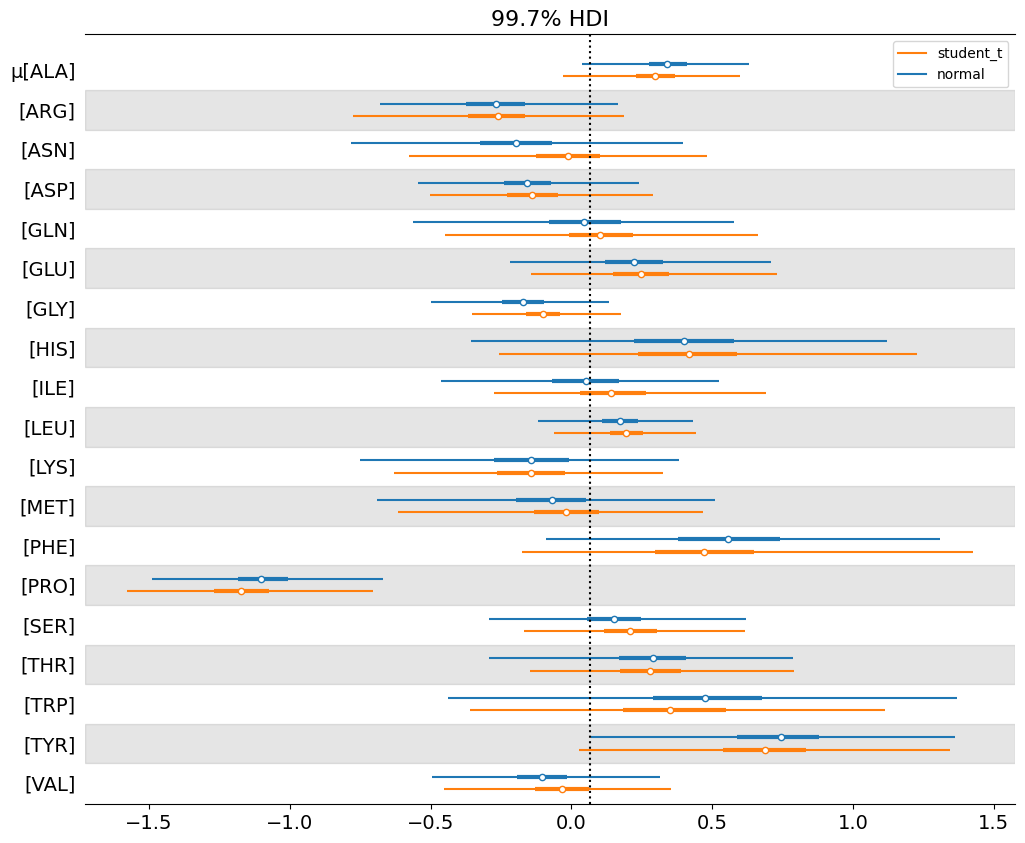

In [7]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_n, idata_cs_s], kind="forestplot",
                      model_names=['normal', 'student_t'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)
#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_n.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

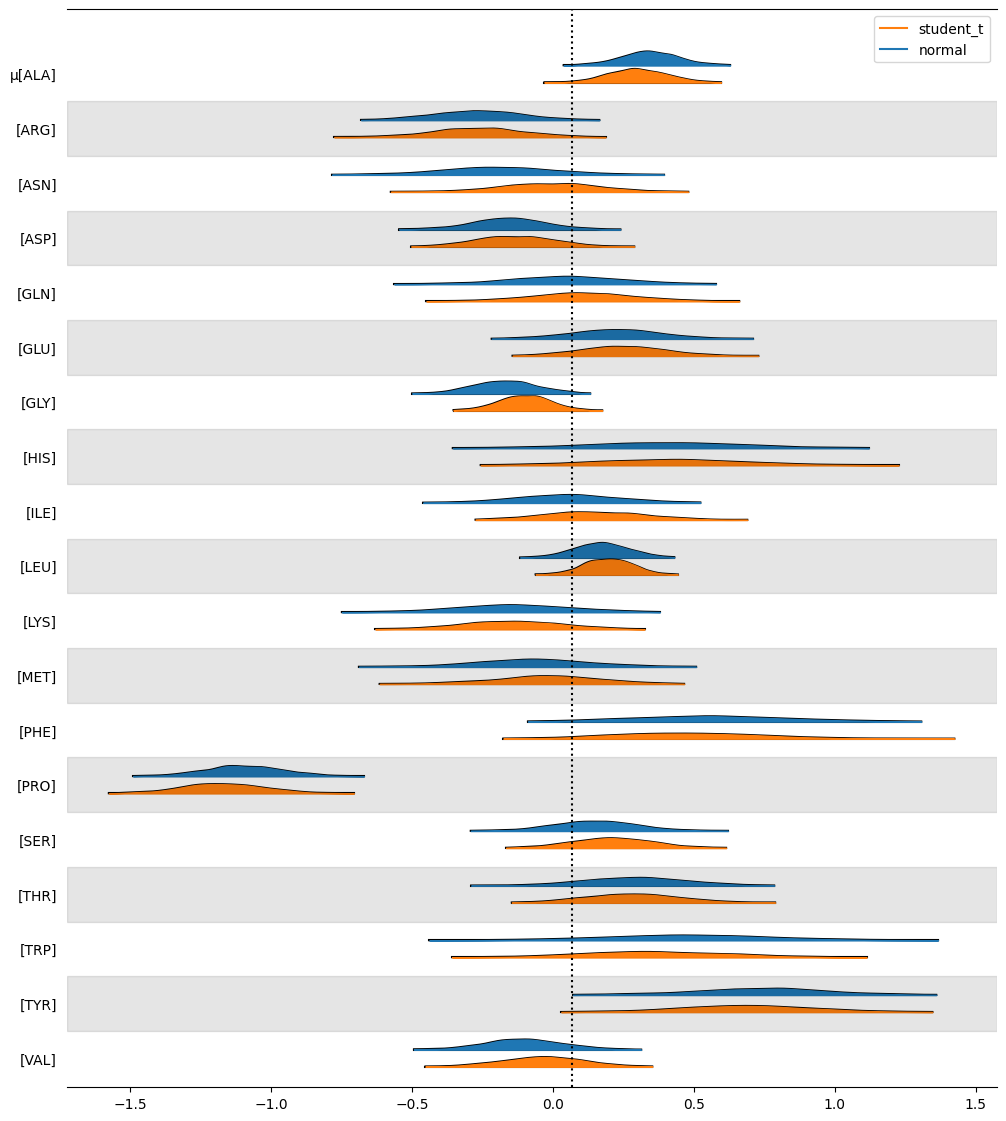

In [10]:
axes = az.plot_forest([idata_cs_n, idata_cs_s], kind="ridgeplot",
                      model_names=['normal', 'student_t'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_n.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

The student t seems to be usually but not always closer to the mean. Weird.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

array([[<Axes: title={'center': 'μ\nALA'}>,
        <Axes: title={'center': 'μ\nARG'}>,
        <Axes: title={'center': 'μ\nASN'}>,
        <Axes: title={'center': 'μ\nASP'}>],
       [<Axes: title={'center': 'μ\nGLN'}>,
        <Axes: title={'center': 'μ\nGLU'}>,
        <Axes: title={'center': 'μ\nGLY'}>,
        <Axes: title={'center': 'μ\nHIS'}>],
       [<Axes: title={'center': 'μ\nILE'}>,
        <Axes: title={'center': 'μ\nLEU'}>,
        <Axes: title={'center': 'μ\nLYS'}>,
        <Axes: title={'center': 'μ\nMET'}>],
       [<Axes: title={'center': 'μ\nPHE'}>,
        <Axes: title={'center': 'μ\nPRO'}>,
        <Axes: title={'center': 'μ\nSER'}>,
        <Axes: title={'center': 'μ\nTHR'}>],
       [<Axes: title={'center': 'μ\nTRP'}>,
        <Axes: title={'center': 'μ\nTYR'}>,
        <Axes: title={'center': 'μ\nVAL'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'σ\nALA'}>,
        <Axes: title={'center':

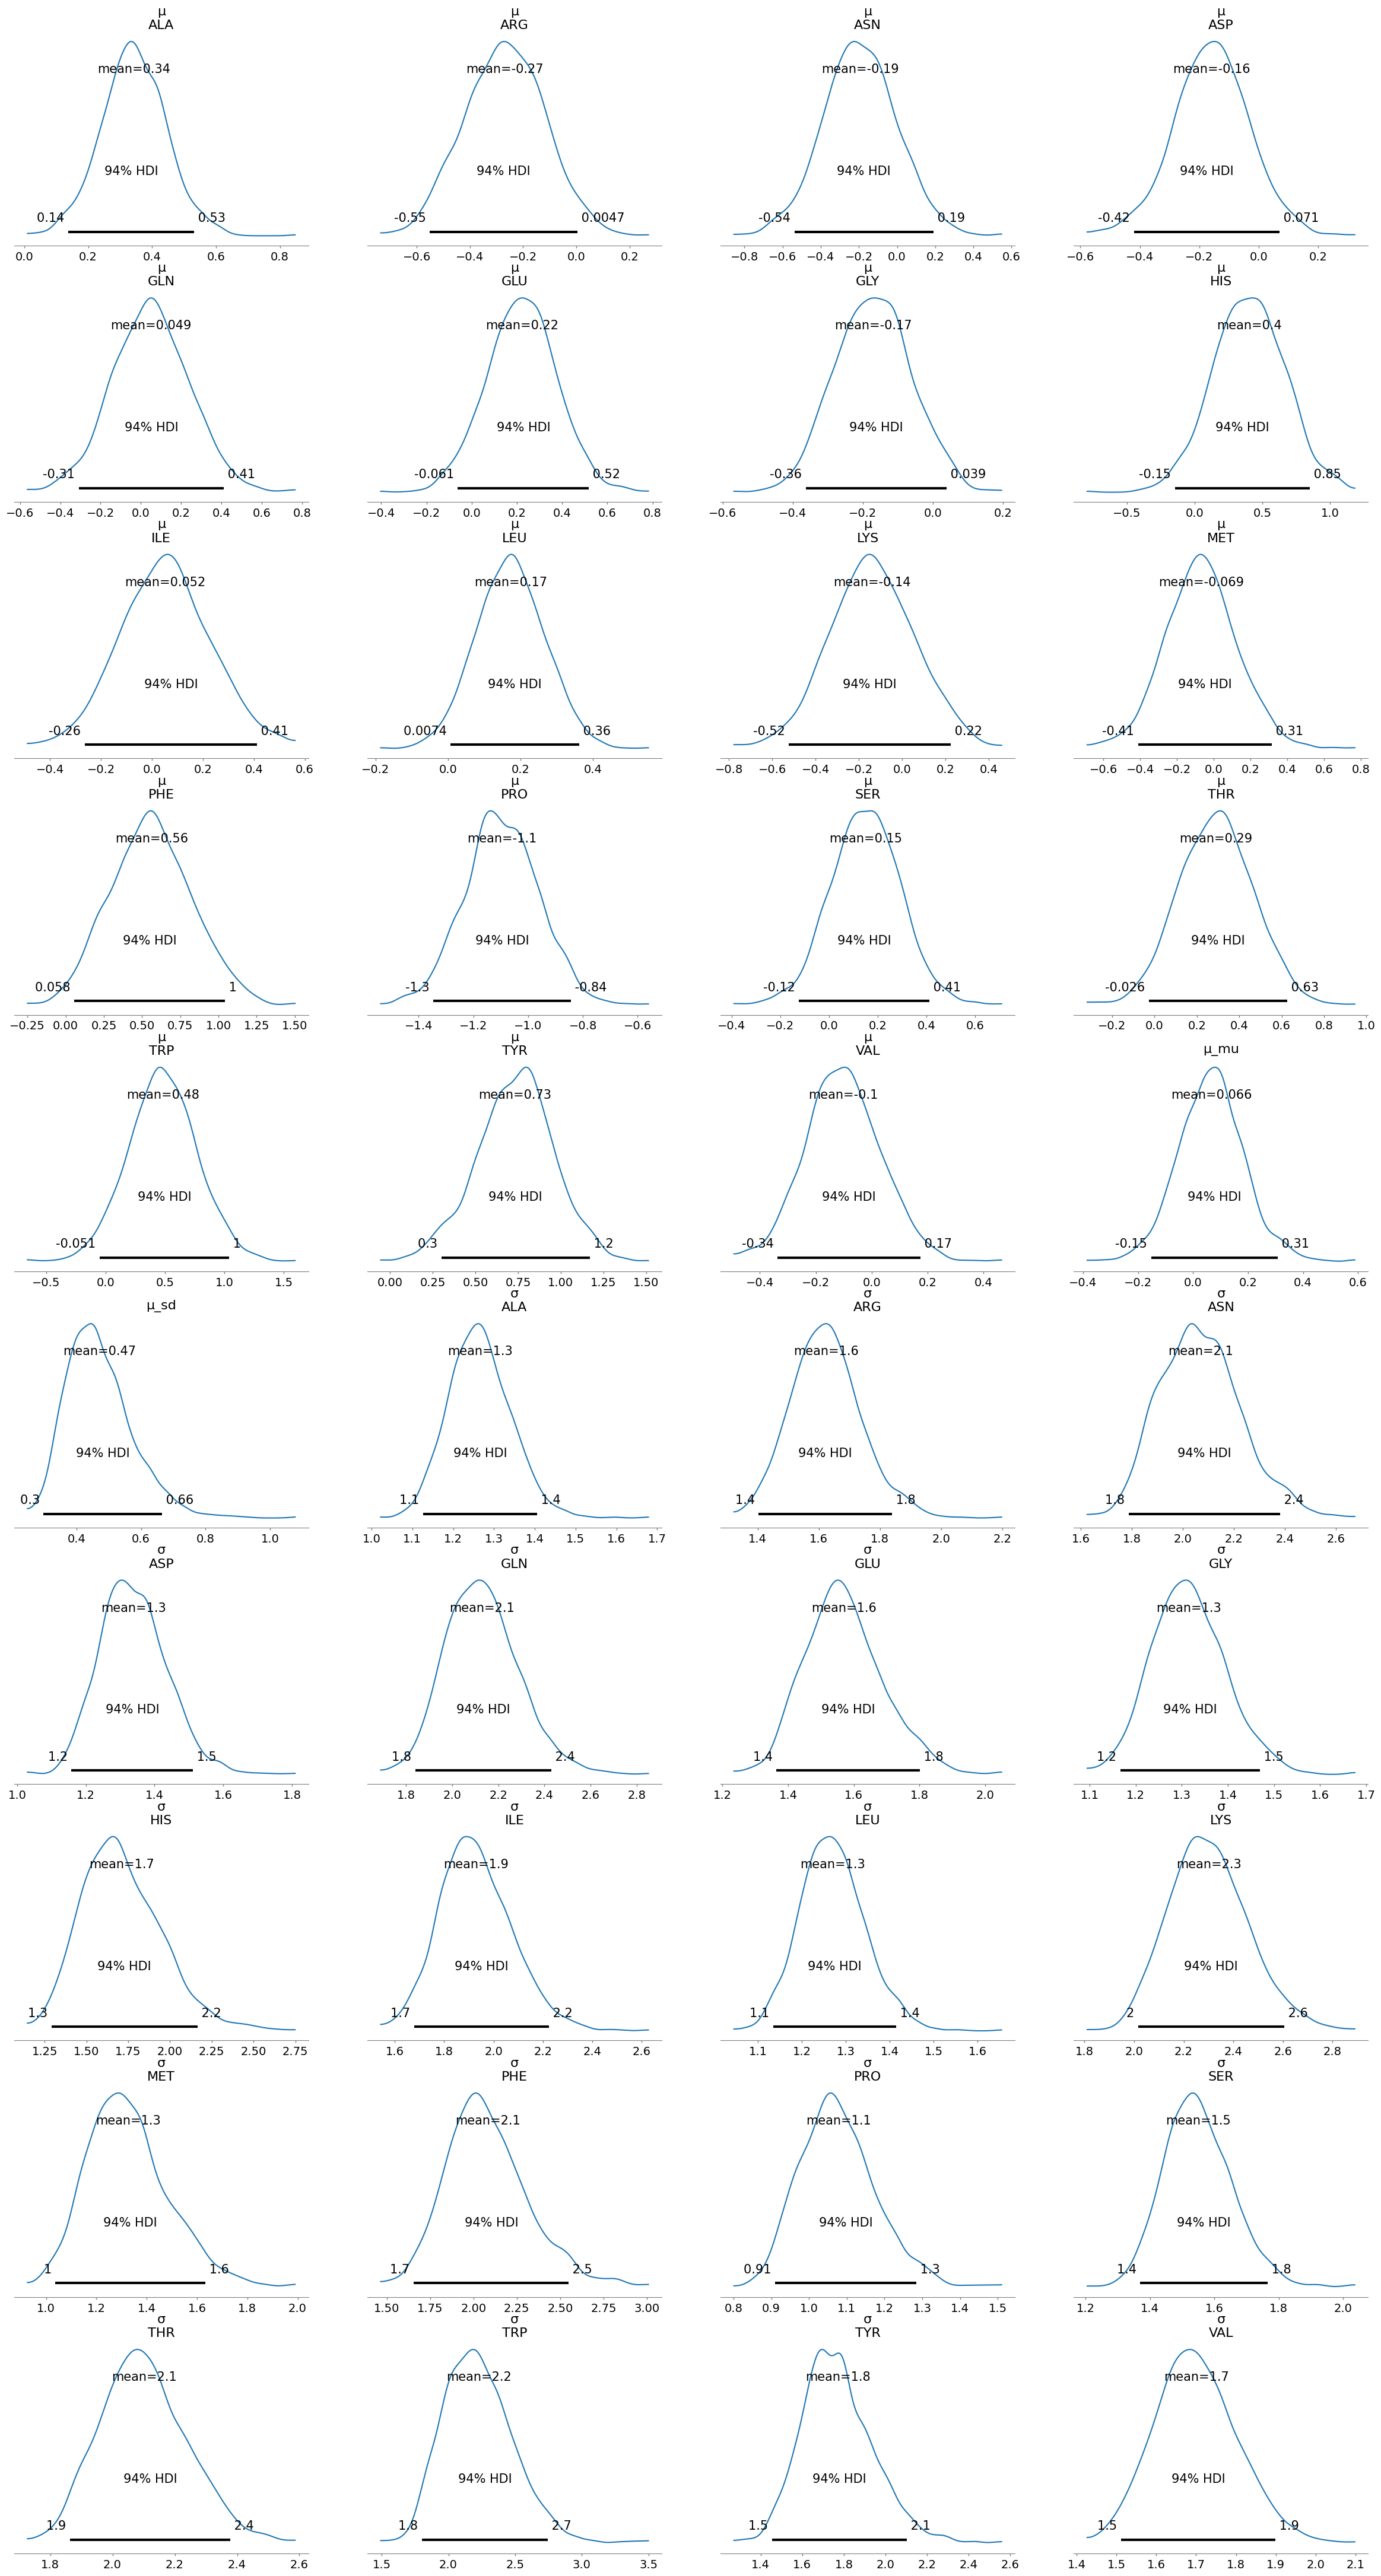

In [11]:
az.plot_posterior(idata_cs_n)

In [12]:
pm.sample_posterior_predictive(idata_cs_n, model=cs_n_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

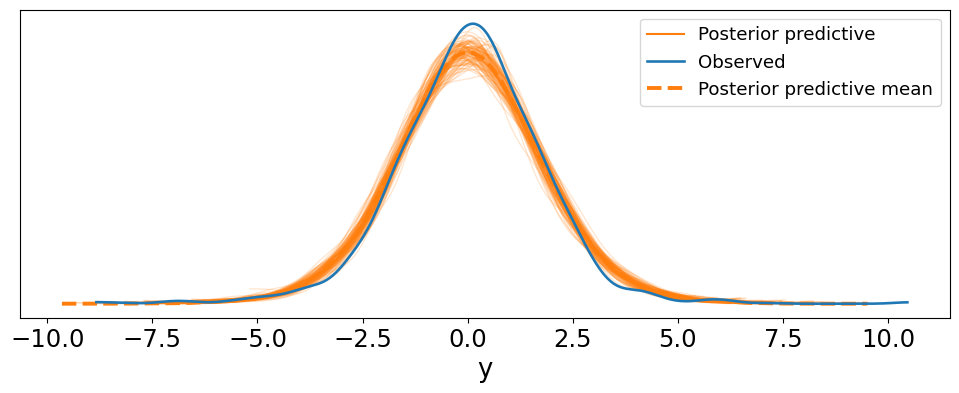

In [13]:
az.plot_ppc(idata_cs_n, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (41) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'μ\nALA'}>,
        <Axes: title={'center': 'μ\nARG'}>,
        <Axes: title={'center': 'μ\nASN'}>,
        <Axes: title={'center': 'μ\nASP'}>],
       [<Axes: title={'center': 'μ\nGLN'}>,
        <Axes: title={'center': 'μ\nGLU'}>,
        <Axes: title={'center': 'μ\nGLY'}>,
        <Axes: title={'center': 'μ\nHIS'}>],
       [<Axes: title={'center': 'μ\nILE'}>,
        <Axes: title={'center': 'μ\nLEU'}>,
        <Axes: title={'center': 'μ\nLYS'}>,
        <Axes: title={'center': 'μ\nMET'}>],
       [<Axes: title={'center': 'μ\nPHE'}>,
        <Axes: title={'center': 'μ\nPRO'}>,
        <Axes: title={'center': 'μ\nSER'}>,
        <Axes: title={'center': 'μ\nTHR'}>],
       [<Axes: title={'center': 'μ\nTRP'}>,
        <Axes: title={'center': 'μ\nTYR'}>,
        <Axes: title={'center': 'μ\nVAL'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_nu'}>,
        <Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': '

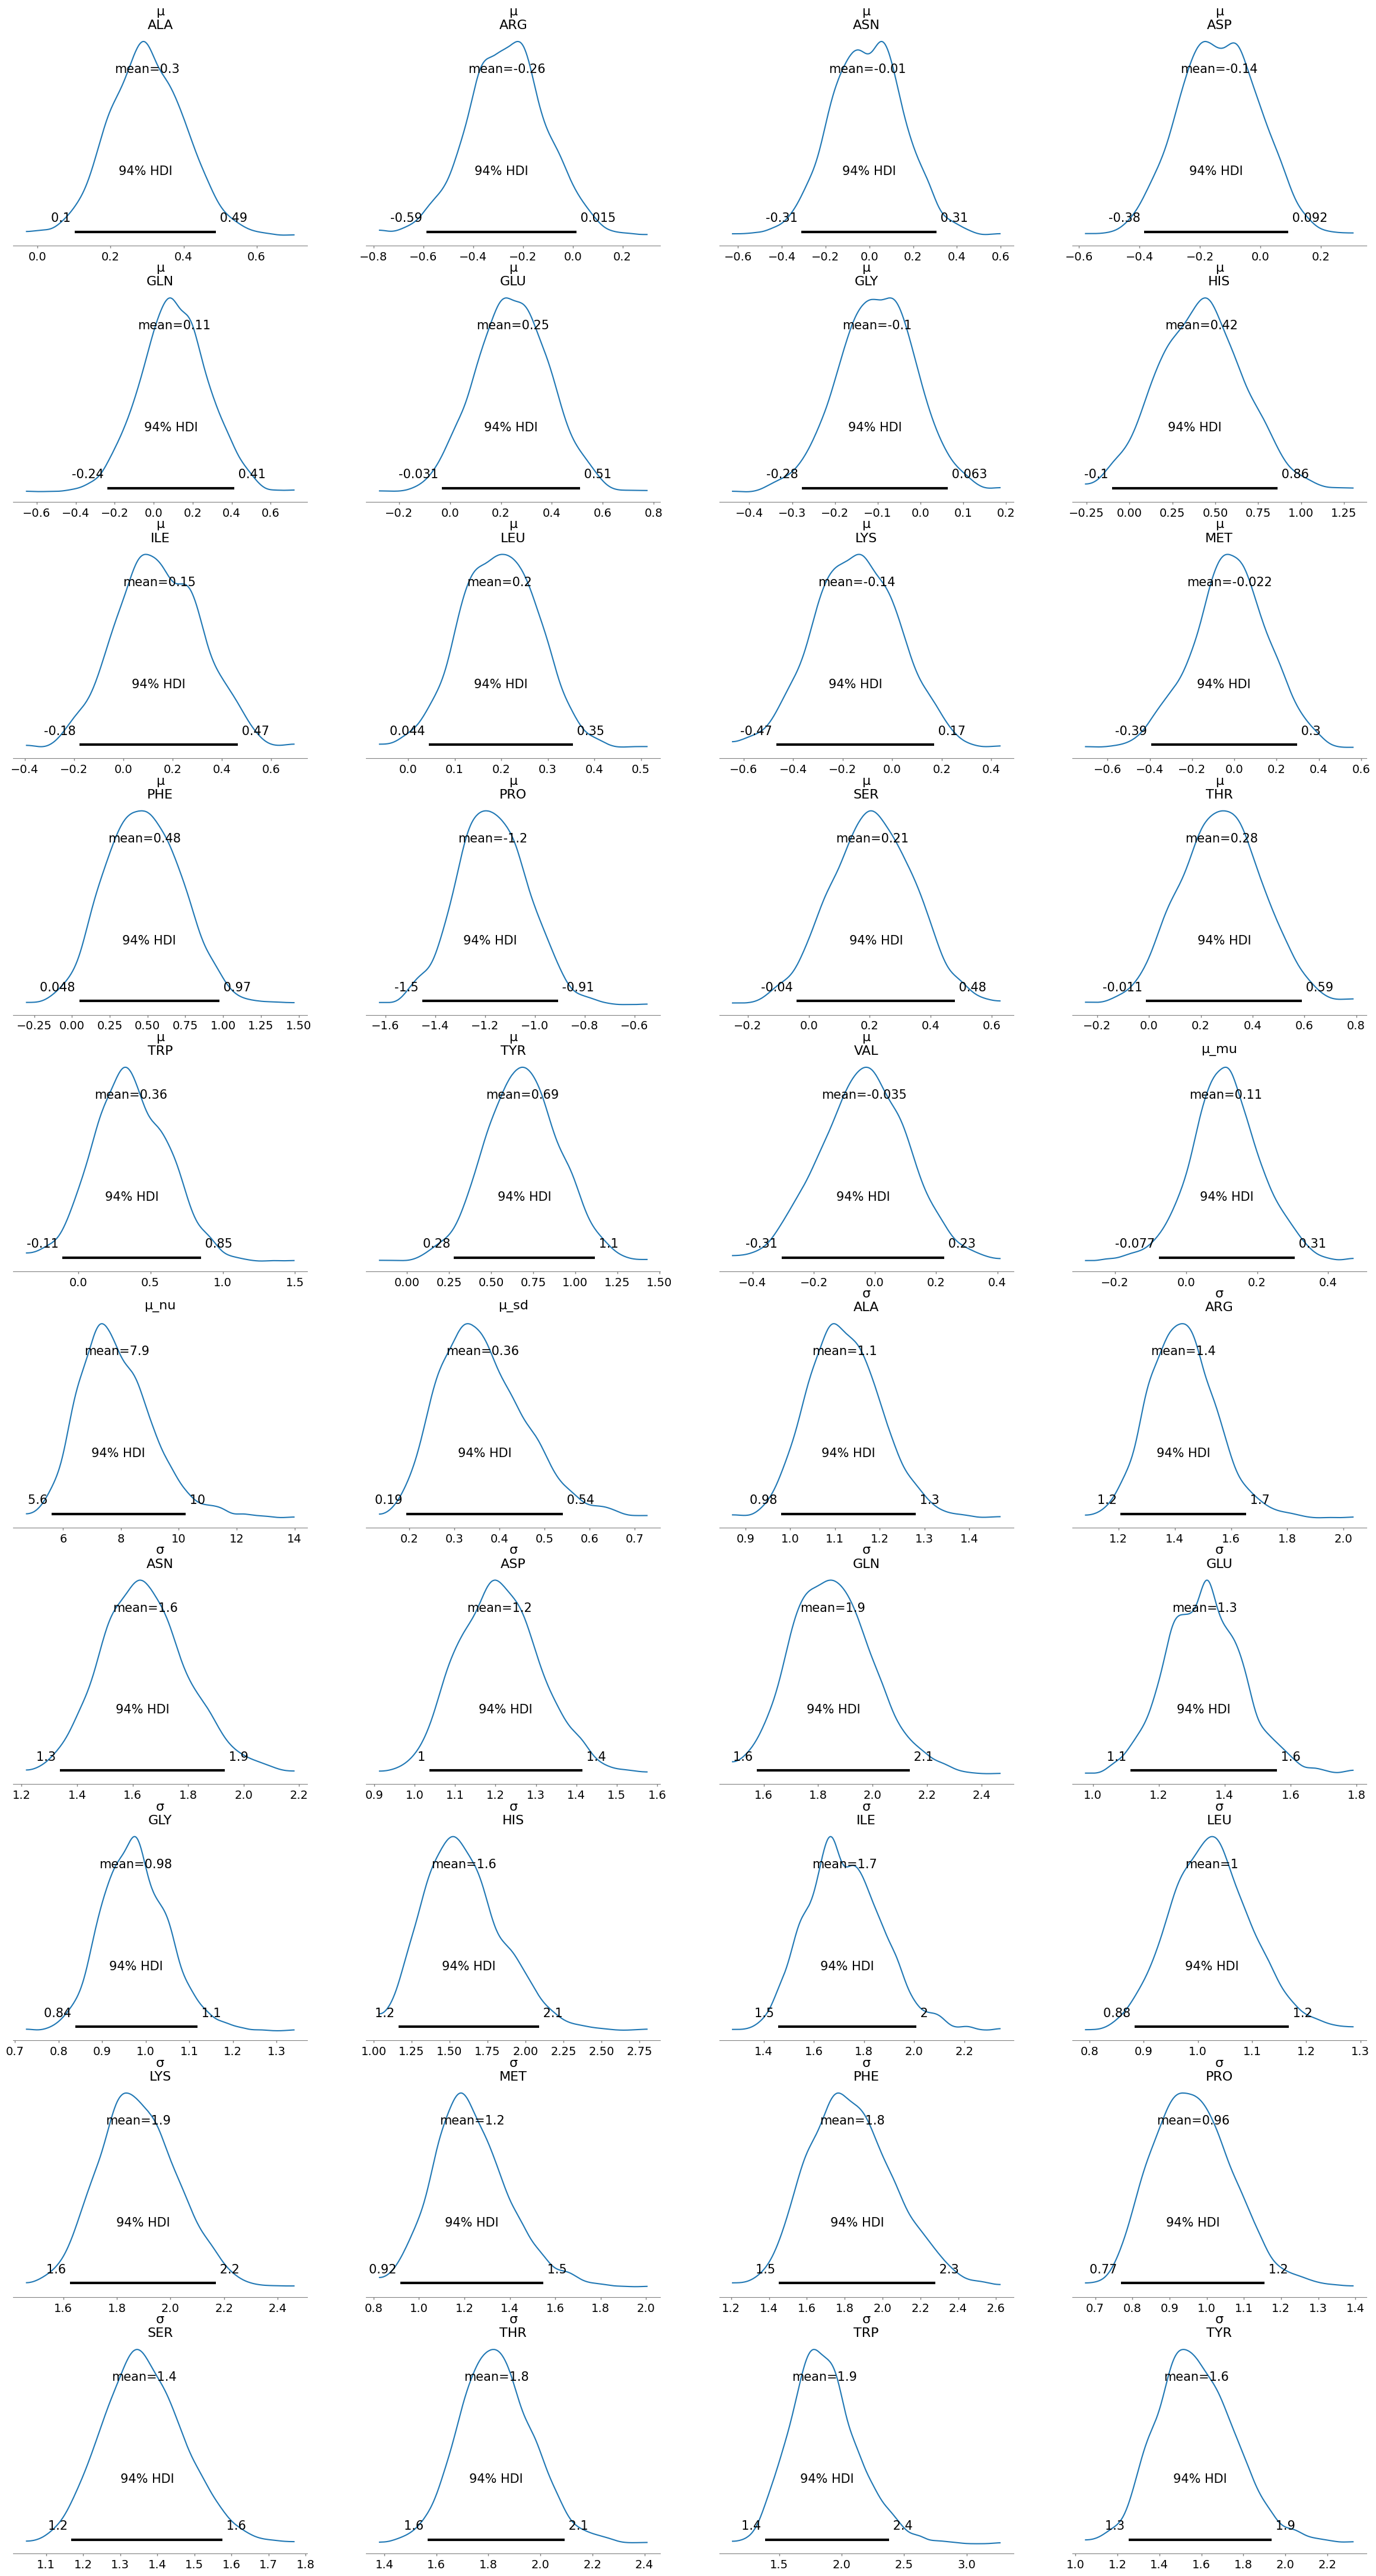

In [14]:
az.plot_posterior(idata_cs_s)

In [15]:
pm.sample_posterior_predictive(idata_cs_s, model=cs_s_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [ ]:
az.plot_ppc(idata_cs_n, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Neither model seems that incredible, both are too shallow, iverpredicting values close to the mean. However, I think that the student t version has this problem a little bit less. I would give a slight edge to student t.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

Ok lets get the data first.

In [16]:
#load the data from your github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [17]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


from matplotlib import pyplot as plt
sccr_data['goals'].plot(kind='hist', bins=20, title='goals')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sccr_data['shots'].plot(kind='hist', bins=20, title='shots')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sccr_data.plot(kind='scatter', x='goals', y='shots', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sccr_data['goals'].plot(kind='line', figsize=(8, 4), title='goals')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
sccr_data['shots'].plot(kind='line', figsize=(8, 4), title='shots')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [20]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Universal Priors
    μ = pm.Beta('μ', alpha = 2,  beta = 20, dims = "pos") # I'm trying to use what would be the mean of the hyperprior to make these values (2/22)

    ν = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

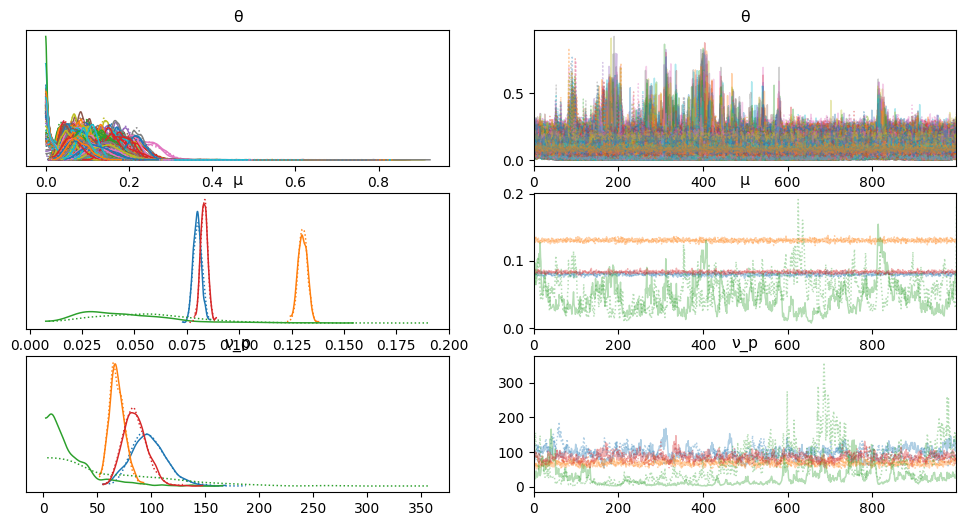

In [21]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr)

There are several differences between how this plot trace and the original went. Most obviously, we don't have any info about the hyperpriors now because they don'y exist (duh). We also have a greater spread in the spikes of the theta values. Similarly, because there is not a hyperprior, the bad goalkeeper data is less able to mess up the rest of the positions. This manifests as better blue, yellow, and red chains ony the right in both mu and nu_p.

In [22]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.002 0.9999 1.001 ... 1.003 1.0 1.005
    μ        (pos) float64 32B 1.003 1.001 1.082 0.9996
    ν_p      (pos) float64 32B 1.012 0.9996 1.445 1.003

We see the lessened spillover of GK's problems here too. GK has a really bad R hat value (1.445) but other positions are more ok than in the heirarchical model. OVerall, this should mean that the non GK positions are predicted slightly better

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

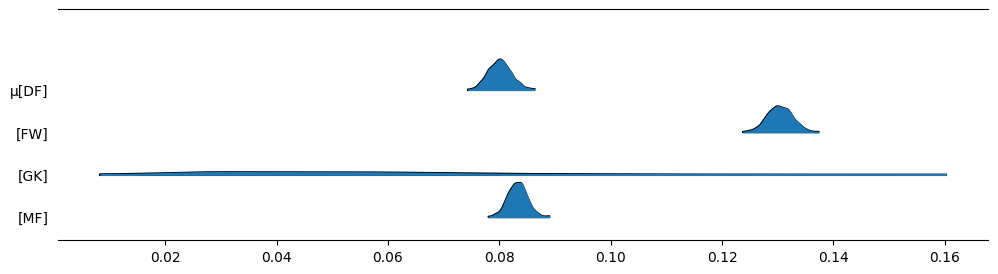

In [49]:
az.plot_forest(idata_sccr, var_names=['μ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The model still has no idea what to do with GK (even less of an idea than in the heirarchical, since the hdi zone noew extends down to almost 0 and up to about .16). Also, the other positions have slightly taller, more focused distributions (prolly because they aren't being clouded as much by the GK).

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [50]:
#Filter out the goalkeepers
sccr_data_nonGK = sccr_data[sccr_data['position'] != 'GK'].copy()

sccr_data_nonGK


,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [51]:
#remove the (now empty) goalkeeper category
sccr_data_nonGK['position'] = sccr_data_nonGK['position'].cat.remove_unused_categories()

sccr_data_nonGK['position'].cat.categories

Index(['DF', 'FW', 'MF'], dtype='object')

No more goalkeepers!

Now we just need to rebuild our grouping and run the model

In [65]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx_nonGK = sccr_data_nonGK.position.cat.codes.values

#an array of the four strings that represent position
pos_codes_nonGK = sccr_data_nonGK.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords_nonGK = {"pos": pos_codes_nonGK}

In [66]:
with pm.Model(coords=sccr_coords_nonGK) as sccr_hierarchical_nonGK:
    # Hyperpriors
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    # Priors for each position (hierarchical part)
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")
    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")


    # Player-level parameter
    θ = pm.Beta('θ', mu=μ_p[pos_idx_nonGK], nu=ν_p[pos_idx_nonGK])

    # Observed data
    _ = pm.Binomial('gs',
                    n=sccr_data_nonGK.shots.values,
                    p=θ,
                    observed=sccr_data_nonGK.goals.values)

    # Sampling
    idata_sccr_h_nonGK = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

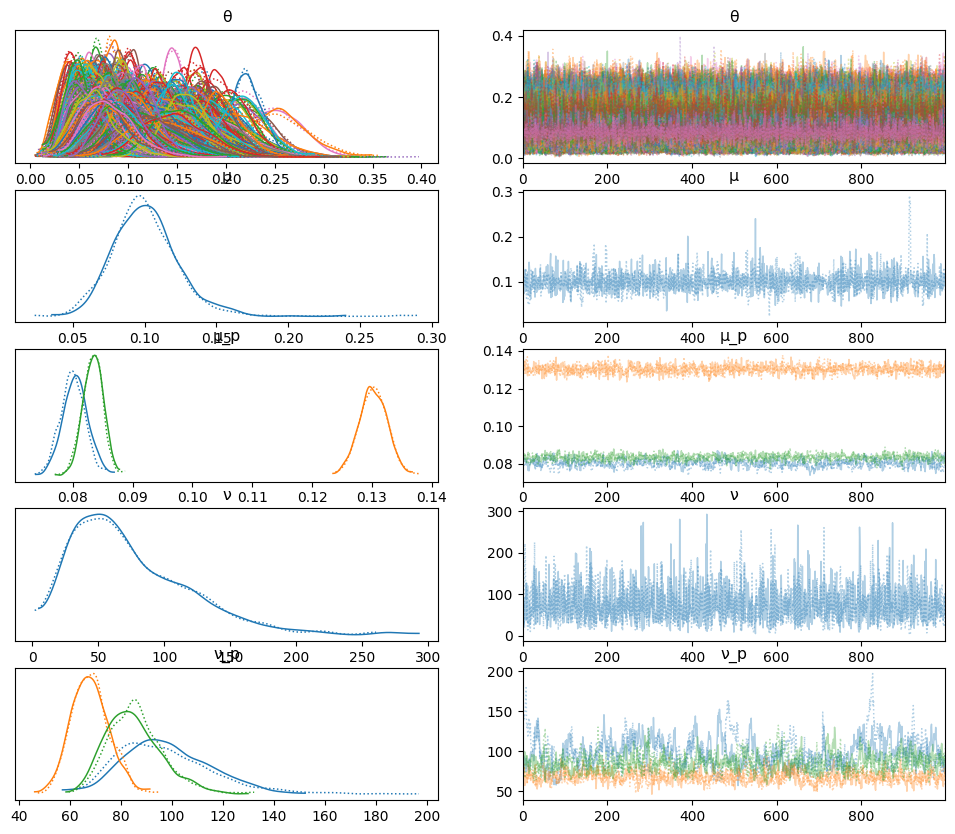

In [67]:
az.plot_trace(idata_sccr_h_nonGK)

In [68]:
az.rhat(idata_sccr_h_nonGK)


<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.003 1.001 1.001 1.002 ... 1.003 1.001 1.0
    μ        float64 8B 0.9997
    μ_p      (pos) float64 24B 1.014 1.002 1.001
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.005 1.004 1.008

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

So, we don't have a whole category that our model has no idea what to do with, however, our chains are still pretty bad. Just about every r value is outside of the good range and i don't really know why.

The theta values seem more spread out than before. Our mu and nu values for the individual positions don't visually seem that different, but that overal mu has spread out a little bit.

The new model was way easier to process (about half speed), and I bet that would go up even more if i could fix whatever thing is causing the chains to be bad.

As far as what we lose and gain by dropping GKs: We lose some information. Goalkeepers' shooting statistics aren't 100% irrelavant and by leaving them out, our model is necessarily "missing out" on some information. We gain, however, clarity about the remaining positions (at least I hope we would, my model doesn't really show that). Goal keeper's shooting habits are fundamentally different from other positions, so by excluding them, we can narrow our focus and zoom in on the trends specific to field positions.